In [179]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from minlora import add_lora, apply_to_lora, disable_lora, enable_lora, get_lora_params, merge_lora, name_is_lora, remove_lora, load_multiple_lora, select_lora

from sklearn.decomposition import PCA

In [2]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

In [43]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """

    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    output_colors = [color_map[chem] for chem in output_labels]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    unique_labels = sorted(list(set(output_labels)))
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_labels,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [220]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()

      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out_clone = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out_clone]

      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, input_frequencies[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [6]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings' or 'conditions'
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    # generate a list of random indices of len = noise_pct% of target location and change values at each index to a random number
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = random.random()
    input_list.append(input_spectra)

    condition_encodings = spectra[list(columns)][-12:].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = random.random()
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = random.random()
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        labels.append(list(spectra[col][915:-12]))
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    # input_data = nn.functional.normalize(input_data)
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    # all_data = torch.cat((input_data.unsqueeze(0), all_true_vals.unsqueeze(0)), dim=0)
    # normalized_data = nn.functional.normalize(all_data)
    # input_data = normalized_data[0]
    # all_true_vals = normalized_data[1]
    # all_true_vals = nn.functional.normalize(all_true_vals)
    input_data = TensorDataset(input_data, all_true_vals, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [122]:
def create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if test_chem in col]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  for col in all_test_chem_columns:
    instrument_encoding = list(spectra[col][-12:])
    # filter out the test instrument type
    if instrument_encoding.index(1) == instrument_idx:
      test_cols.append(col)

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)

  return train_input, test_input

In [9]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()

    # self.denoiser = nn.Sequential(
    #   nn.Linear(1439,2123),
    #   nn.LeakyReLU(inplace=True),
    #   nn.Linear(2123,50),
    #   nn.LeakyReLU(inplace=True),
    #   nn.Linear(50,2123),
    #   nn.LeakyReLU(inplace=True),
    #   nn.Linear(2123,1439),
    #   # nn.LeakyReLU(inplace=True),
    #   # nn.Linear(1439, 1439),
    # #   nn.LeakyReLU(inplace=True),
    # #   nn.Linear(1439, 1439),
    # )
    self.denoiser = nn.Sequential(
      nn.Linear(1439,2123),
      nn.LeakyReLU(inplace=True),
      nn.Linear(2123,1439),
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [275]:
def train_denoiser(model, data, test_data, sorted_chemical_names, epochs, loss_type, train_loss_log = [], test_loss_log = []):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.
    - loss_type (str): One of: 'spectra', 'conditions' or 'embneddings'

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    if loss_type not in ['spectra', 'embeddings', 'conditions', None]:
        raise ValueError("Invalid value for 'loss_type'. Please choose from 'spectra', 'embeddings', 'conditions'")

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        with torch.no_grad(): 
            test_loss = 0
            for batch, true_vals, labels in test_data:
                output_0 = model(batch)
                output_1= model(output_0)
                output_2= model(output_1)
                # loss = loss_o_0 + loss_o_1 + loss_o_2...
                # loss goes + stays at 0 - definition of attracting fixed point
                if loss_type == 'spectra':
                    output_spectra = output[:, :915]
                    true_spectra = true_vals[:,:915]
                    loss = model.criterion(output_spectra, true_spectra)
                    # loss = spectra_loss
                if loss_type == 'conditions':
                    output_conditions = output[:, 915:927]
                    true_conditions = true_vals[:, 915:927]
                    loss = model.criterion(output_conditions, true_conditions)
                    # loss=condition_loss
                if loss_type == 'embeddings':
                    output_embeddings = output[:, 927:]
                    true_embeddings = true_vals[:, 927:]
                    loss = model.criterion(output_embeddings, true_embeddings)
                test_loss += loss 

            average_test_loss = test_loss/len(test_data)
            
        # accumulate epoch output and loss
        epoch_training_loss = 0
        epoch_training_combined_loss = 0
        for batch, true_vals, labels in data:
            output = model(batch)
            # loss = model.criterion(output, true_vals)
            # loss = spectra_loss
            # loss =  .05 * spectra_loss + .1 * condition_loss + embedding_loss
            if loss_type == 'spectra':
                output_spectra = output[:, :915]
                true_spectra = true_vals[:,:915]
                spectra_loss = model.criterion(output_spectra, true_spectra)
                epoch_training_loss += spectra_loss
                # loss = spectra_loss
            if loss_type == 'conditions':
                output_conditions = output[:, 915:927]
                true_conditions = true_vals[:, 915:927]
                condition_loss = model.criterion(output_conditions, true_conditions)
                epoch_training_loss += condition_loss
                # loss=condition_loss
            if loss_type == 'embeddings':
                output_embeddings = output[:, 927:]
                true_embeddings = true_vals[:, 927:]
                embedding_loss = model.criterion(output_embeddings, true_embeddings)
                epoch_training_loss += embedding_loss
                # loss = embedding_loss
            # epoch_training_loss += loss
            epoch_training_combined_loss += model.criterion(output, true_vals)

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output, chem_names, true_vals):
                    model_output.append(denoised_vector)
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)
        

        average_loss = epoch_training_loss/len(data)
        average_total_loss = epoch_training_combined_loss/len(data)

        train_loss_log.append(average_loss.detach().numpy())
        test_loss_log.append(average_test_loss.detach().numpy())
        
        if (epoch+1) % 10 == 0:
            # print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, average_loss))
            print('Epoch[{}/{}], train loss: {}, test loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), round(float(average_test_loss.detach().numpy()), 6)))
            print(f'Total training loss: {round(float(average_total_loss.detach().numpy()), 6)}')
            print('--------------------------------------------------------')
        
        # if epoch == 0:
        #     print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, average_loss))
        #     print('Epoch[{}/{}], test loss: {}'.format(epoch+1, epochs, epoch_test_loss))

    return model_output, output_labels, true_vals_output, train_loss_log, test_loss_log

In [11]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [123]:
# train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc='embeddings', noise_pct=1)

In [266]:
loss_type = 'spectra'
train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc=loss_type, noise_pct=1)
denoiser = Denoiser()
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_embedding, test_noisy_embedding, all_chemical_names, epochs=100, loss_type=loss_type, train_loss_log = [], test_loss_log = [])

Epoch[10/100], train loss: 17.292089, test loss: 12.701977
Total training loss: 11.447534
--------------------------------------------------------
Epoch[20/100], train loss: 13.240511, test loss: 10.716373
Total training loss: 10.819942
--------------------------------------------------------
Epoch[30/100], train loss: 11.26375, test loss: 8.487205
Total training loss: 12.323317
--------------------------------------------------------
Epoch[40/100], train loss: 9.802407, test loss: 6.592816
Total training loss: 14.970223
--------------------------------------------------------
Epoch[50/100], train loss: 8.690662, test loss: 5.892265
Total training loss: 18.330244
--------------------------------------------------------
Epoch[60/100], train loss: 7.835171, test loss: 5.833797
Total training loss: 20.104805
--------------------------------------------------------
Epoch[70/100], train loss: 7.117465, test loss: 5.891403
Total training loss: 22.873049
--------------------------------------

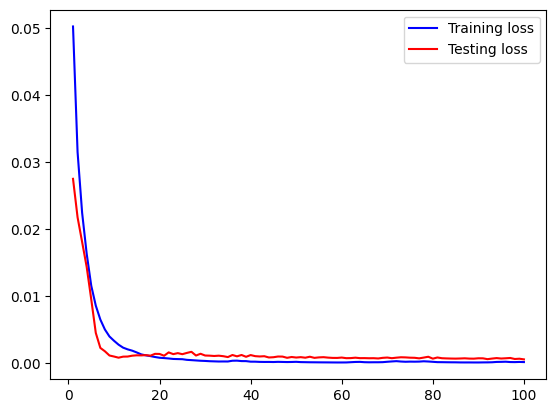

In [244]:
# create x-axis values
epochs = range(1, len(train_loss_log) + 1)

# plot train and test loss
plt.plot(epochs, train_loss_log, 'b', label='Training loss')
plt.plot(epochs, test_loss_log, 'r', label='Testing loss')
plt.legend()
plt.show()

In [215]:
# true_spectra = [vec[:915].detach().numpy() for vec in true_values]
# output_spectra = [vec[:915].detach().numpy() for vec in model_output]
# plot_results(true_spectra, output_spectra, output_labels, idx=[0,5])

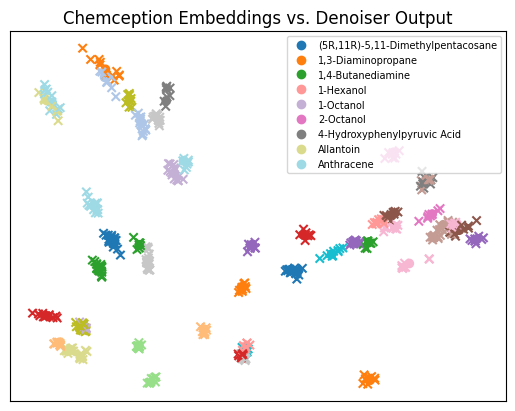

In [245]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

In [267]:
denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_tmp.pth'
torch.save(denoiser.state_dict(), denoiser_path)

In [29]:
# denoiser = Denoiser()
# denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_fine_tuned.pth'
# denoiser.load_state_dict(torch.load(denoiser_path))

<All keys matched successfully>

In [269]:
loss_type = 'embeddings'
train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc=loss_type, noise_pct=1)

denoiser = Denoiser()
denoiser.load_state_dict(torch.load(denoiser_path))
for i, param in enumerate(denoiser.parameters()):
    if i in [0, 1, 2, 3]: # 4, 5:  # freeze specified layers
        param.requires_grad = False

# define optimizer only for trainable parameters
denoiser.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, denoiser.parameters()), lr=.0001)

model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_embedding, test_noisy_embedding, all_chemical_names, epochs=100, loss_type=loss_type, train_loss_log = [], test_loss_log = [])

Epoch[10/100], train loss: 0.685312, test loss: 0.554491
Total training loss: 30.030783
--------------------------------------------------------
Epoch[20/100], train loss: 0.260828, test loss: 0.233008
Total training loss: 28.201595
--------------------------------------------------------
Epoch[30/100], train loss: 0.152037, test loss: 0.144868
Total training loss: 27.439529
--------------------------------------------------------
Epoch[40/100], train loss: 0.108437, test loss: 0.105013
Total training loss: 26.874352
--------------------------------------------------------
Epoch[50/100], train loss: 0.08511, test loss: 0.088705
Total training loss: 26.496916
--------------------------------------------------------
Epoch[60/100], train loss: 0.071461, test loss: 0.080962
Total training loss: 26.132307
--------------------------------------------------------
Epoch[70/100], train loss: 0.062633, test loss: 0.074244
Total training loss: 25.816719
-------------------------------------------

In [261]:
denoiser.eval()
test_output = []
test_labels = []
test_true_values = []
test_loss = 0

with torch.no_grad(): 
    for batch, true_vals, labels in test_noisy_embedding:
        output = denoiser(batch)
        if loss_type == 'spectra':
            output_spectra = output[:, :915]
            true_spectra = true_vals[:,:915]
            loss = denoiser.criterion(output_spectra, true_spectra)
            # loss = spectra_loss
        if loss_type == 'conditions':
            output_conditions = output[:, 915:927]
            true_conditions = true_vals[:, 915:927]
            loss = denoiser.criterion(output_conditions, true_conditions)
            # loss=condition_loss
        if loss_type == 'embeddings':
            output_embeddings = output[:, 927:]
            true_embeddings = true_vals[:, 927:]
            loss = denoiser.criterion(output_embeddings, true_embeddings)
        test_loss += loss

        chem_names = [all_chemical_names[list(encoding).index(1)] for encoding in labels]
        for denoised_vector, chem_name, true_val in zip(output, chem_names, true_vals):
            test_output.append(denoised_vector)
            test_true_values.append(true_val)
            test_labels.append(chem_name)

    average_loss = test_loss/len(test_noisy_embedding)
    print('Loss =', average_loss)

Loss = tensor(0.0225)


In [250]:
# true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# plot_results(true_spectra, output_spectra, test_labels)

In [1]:
# test_output_embeddings = [vec[-512:].detach().numpy() for vec in test_output]
# # plot_emb_pca(embeddings, test_output_embeddings, test_labels, train_chems)
# plot_emb_pca(embeddings, test_output_embeddings, test_labels, all_chemical_names)

In [272]:
denoiser = Denoiser()

denoiser.load_state_dict(torch.load(denoiser_path))

# add LoRA to denoiser
add_lora(denoiser)

# collect params and pass to optimizer
parameters = [{"params":list(get_lora_params(denoiser))}]
denoiser.optimizer = torch.optim.AdamW(parameters, lr=.0001)

LoRA_loss = 'embeddings'
train_noisy_spectra, test_noisy_spectra = create_dataset(spectra, embeddings, noise_loc=LoRA_loss, noise_pct=1)
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_spectra, test_noisy_spectra, all_chemical_names, epochs=200, loss_type=LoRA_loss , train_loss_log=[], test_loss_log=[])

# export LoRA params
state_dict = denoiser.state_dict()
lora_state_dict = {k:v for k, v in state_dict.items() if name_is_lora(k)}

# merge LoRA params into denoiser
_ = denoiser.load_state_dict(lora_state_dict, strict=False)
merge_lora(denoiser)

Epoch[10/200], train loss: 268.31842, test loss: 107.347969
Total training loss: 142.441254
--------------------------------------------------------
Epoch[20/200], train loss: 86.390099, test loss: 45.145756
Total training loss: 74.699341
--------------------------------------------------------
Epoch[30/200], train loss: 35.649689, test loss: 22.450014
Total training loss: 55.654148
--------------------------------------------------------
Epoch[40/200], train loss: 16.916515, test loss: 12.030885
Total training loss: 47.944397
--------------------------------------------------------
Epoch[50/200], train loss: 9.12374, test loss: 6.510236
Total training loss: 43.685287
--------------------------------------------------------
Epoch[60/200], train loss: 5.555523, test loss: 3.689508
Total training loss: 40.374741
--------------------------------------------------------
Epoch[70/200], train loss: 3.627611, test loss: 2.294484
Total training loss: 37.496429
---------------------------------

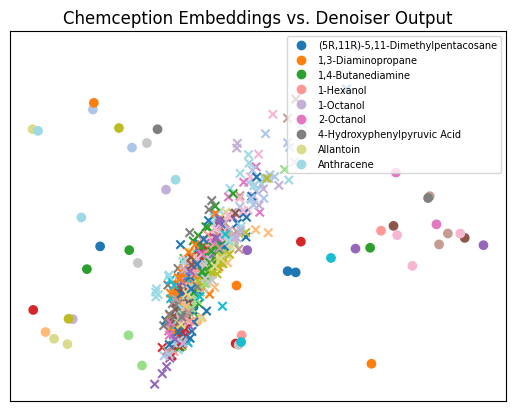

In [273]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

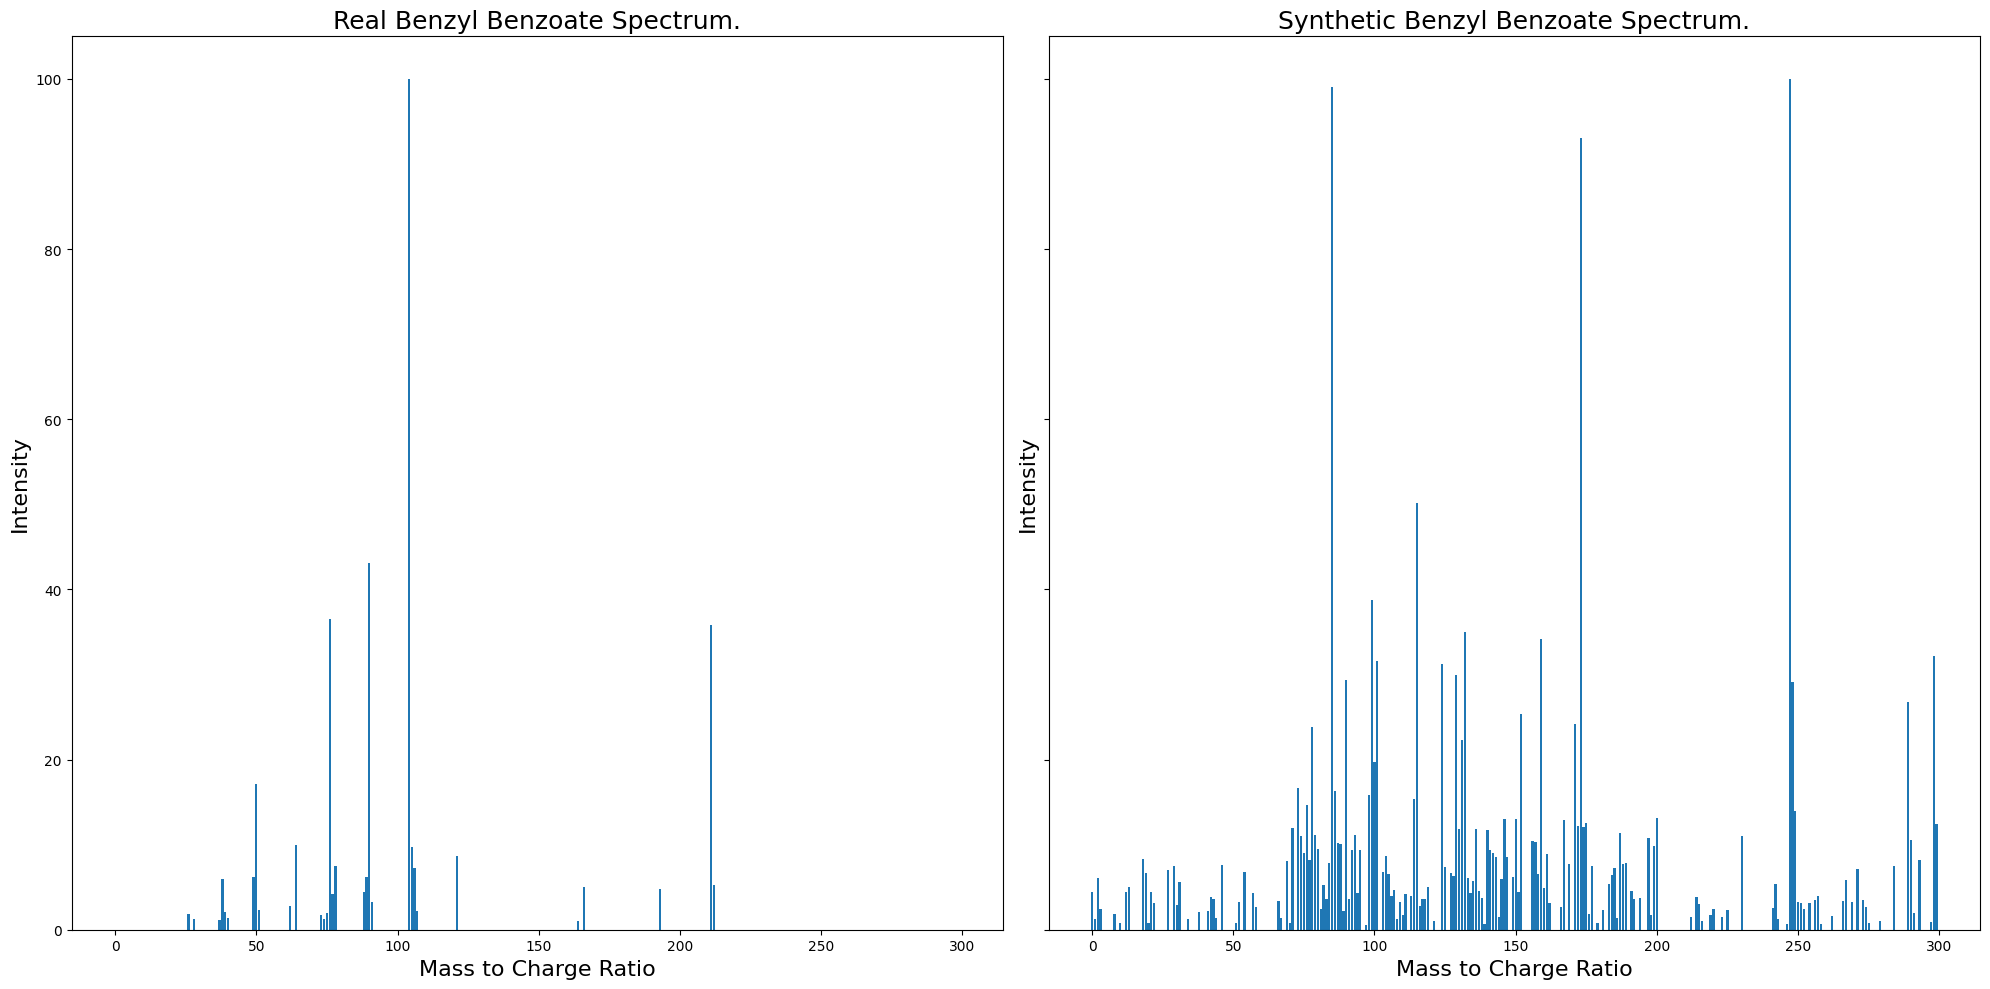

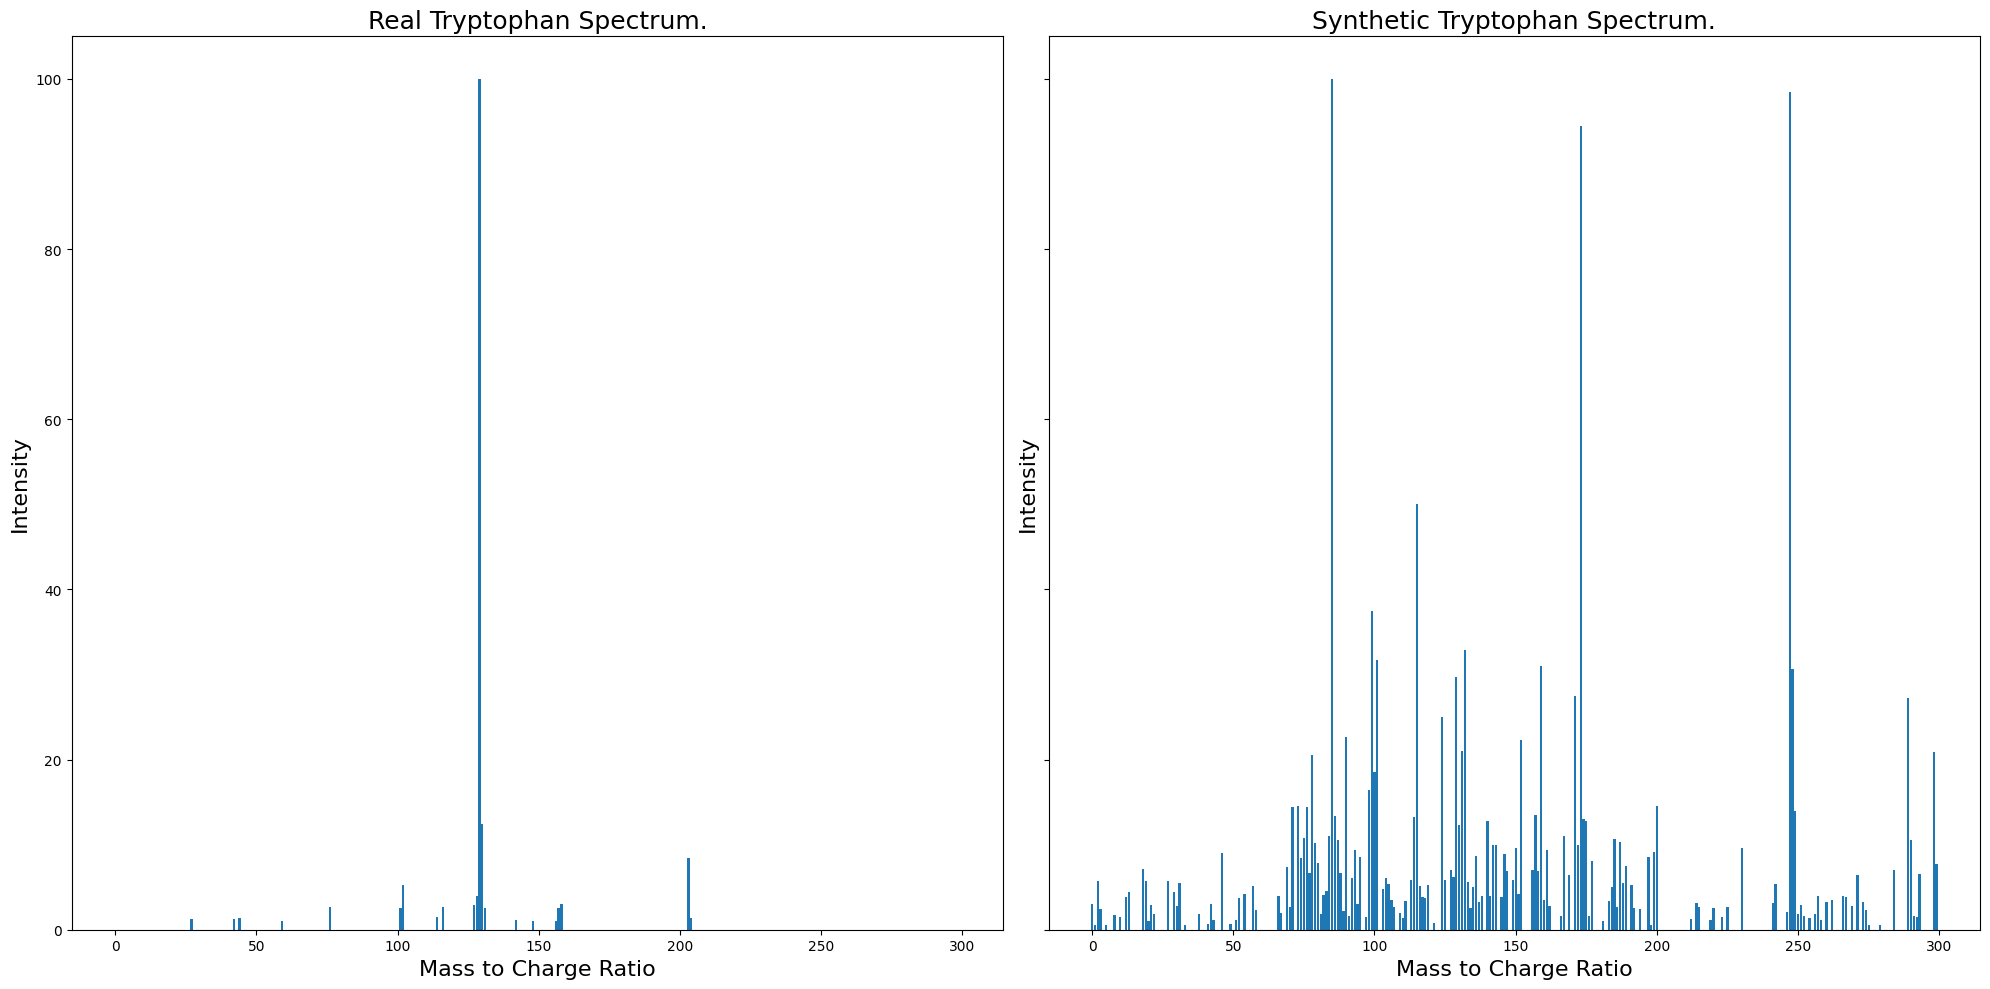

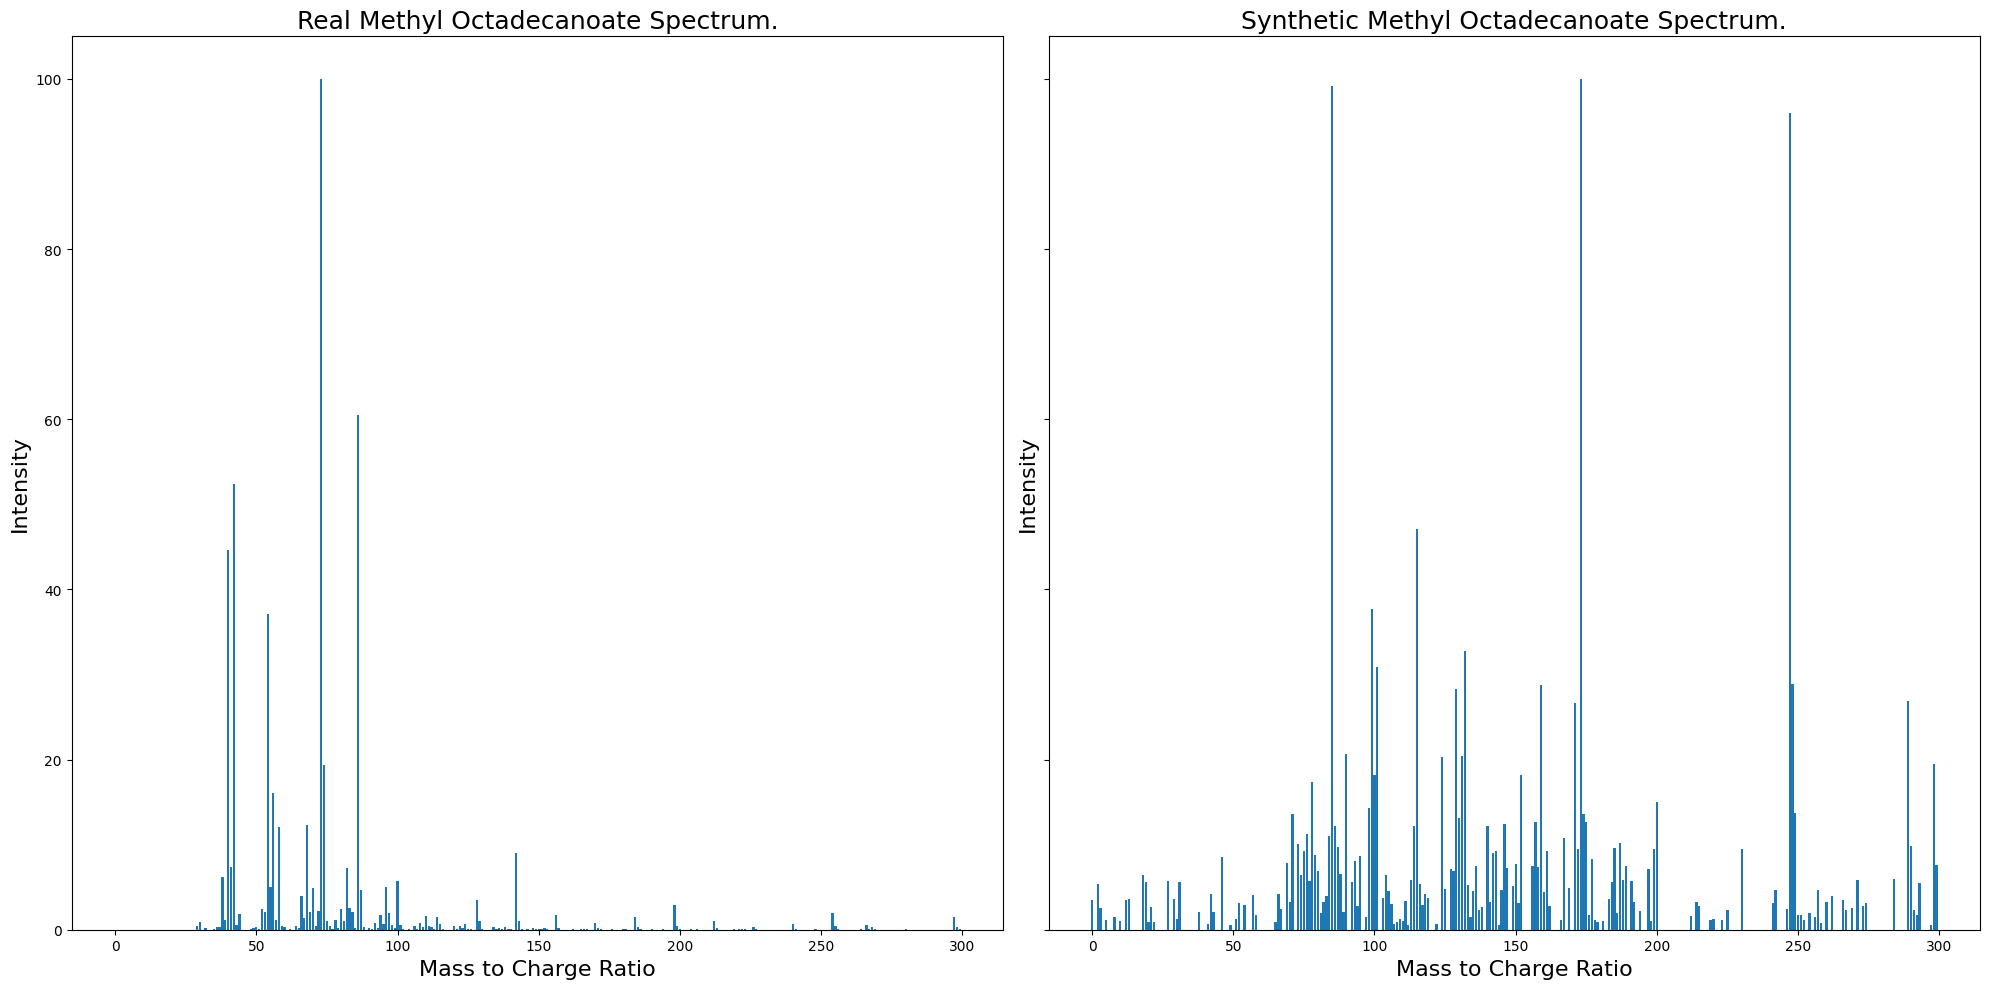

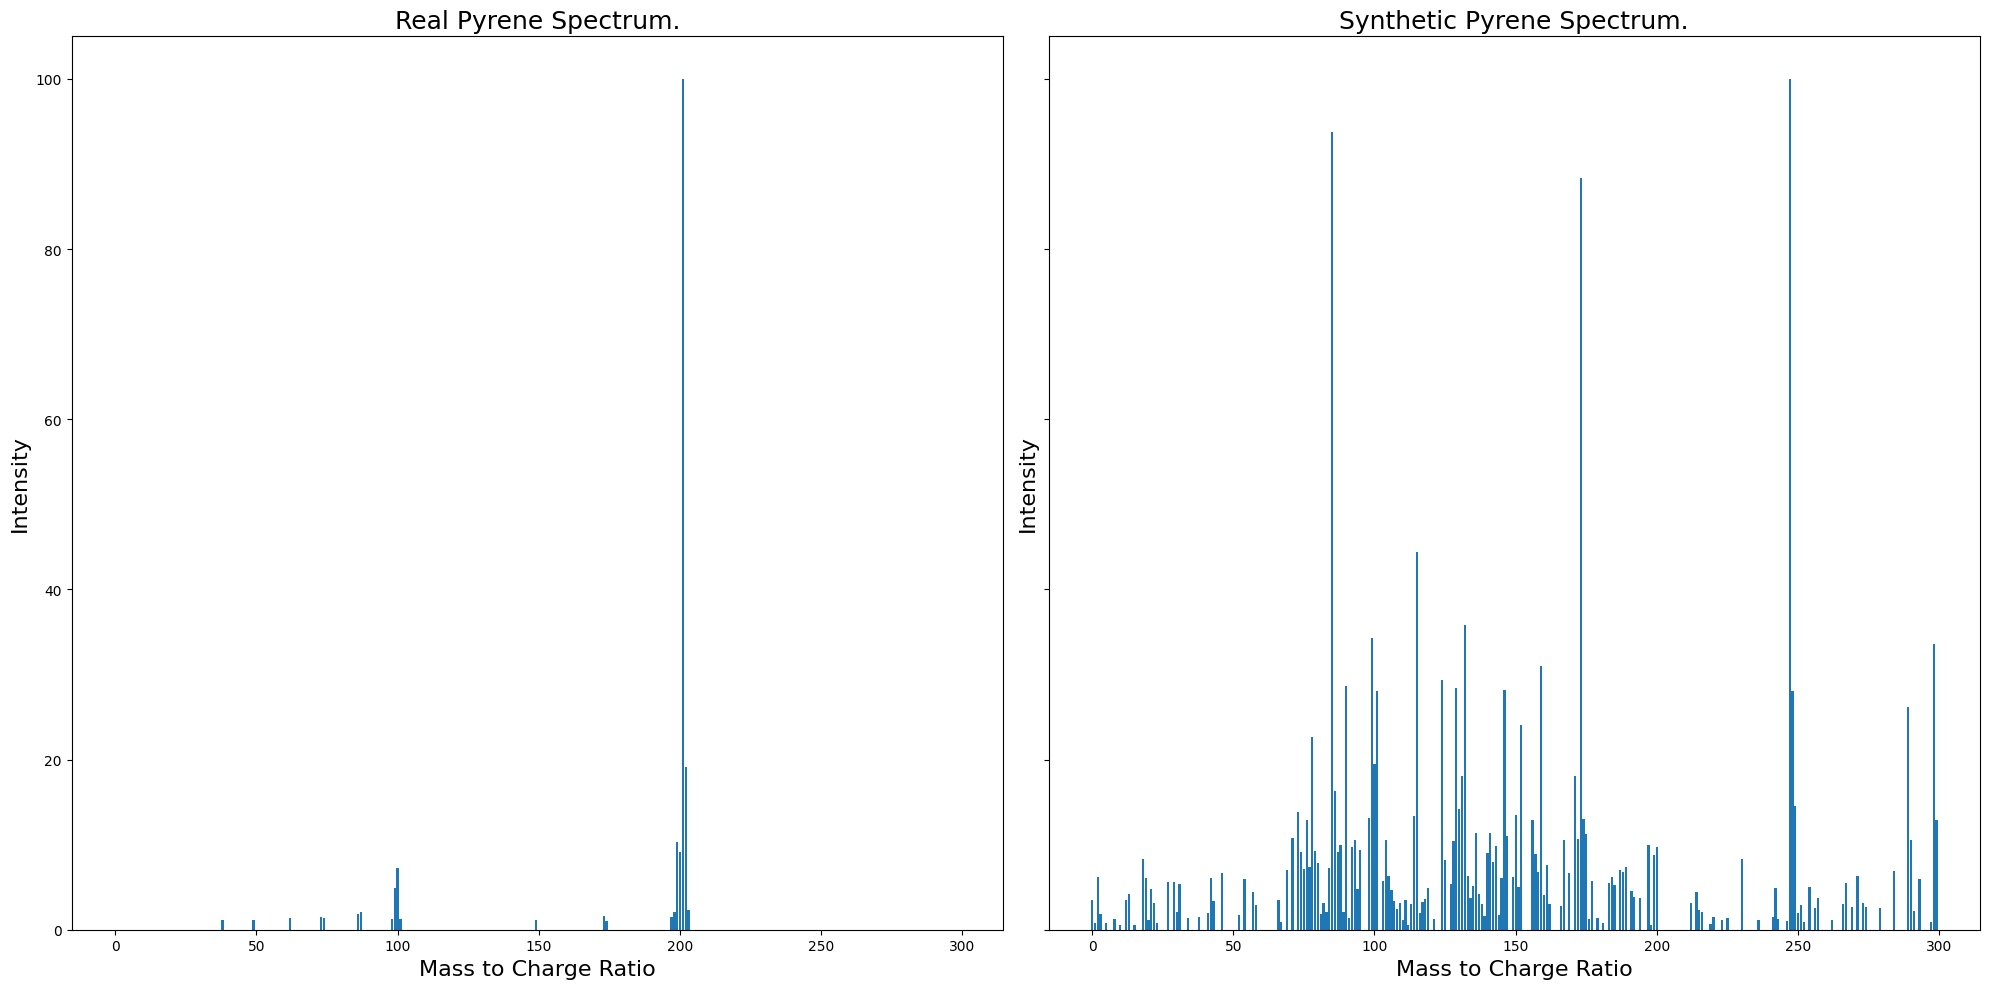

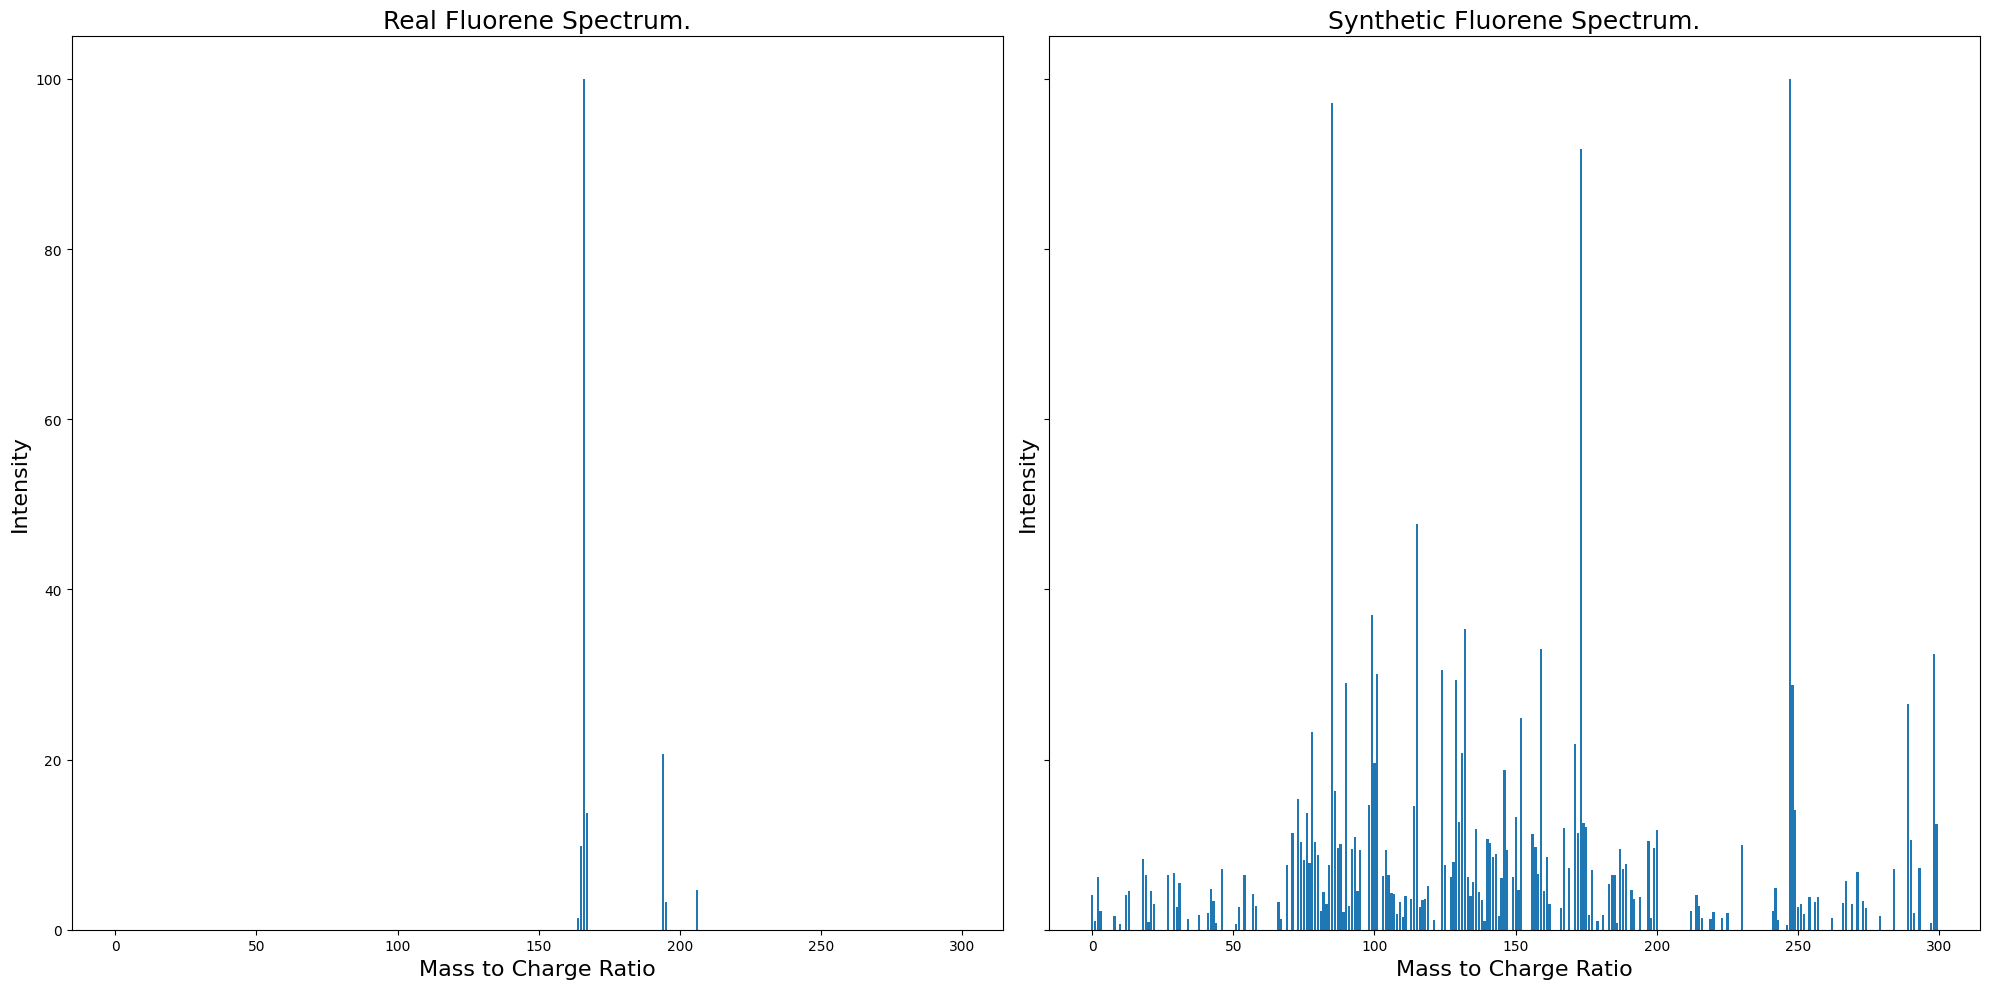

In [274]:
true_spectra = [vec[:915].detach().numpy() for vec in true_values]
output_spectra = [vec[:915].detach().numpy() for vec in model_output]
plot_results(true_spectra, output_spectra, output_labels, idx=[0,5])

# Fine Tuning with smaller learning rate and/or smaller training set

In [ ]:
# train_chems = ['Glutaric Acid', 'Fumaric Acid', 'Malonic Acid', 'Succinic Acid', 'Benzoic Acid', 'Biphenyl']
# train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc='embeddings', noise_pct=1, training_chems=train_chems)

In [ ]:
# denoiser = Denoiser()
# denoiser.load_state_dict(torch.load(denoiser_path))

# denoiser.optimizer = torch.optim.AdamW(denoiser.parameters(), lr=.00001)
# # model_output, output_labels, true_values = train_denoiser(denoiser, train_noisy_embedding, all_chemical_names, epochs=50, loss_type='embedding')
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_embedding, test_noisy_embedding, all_chemical_names, epochs=100, loss_type=loss_type, train_loss_log=train_loss_log, test_loss_log=test_loss_log)

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(train_loss_log[20:]) + 1)

# Plotting the loss
plt.plot(epochs, train_loss_log[20:], 'b', label='Training loss')
plt.plot(epochs, test_loss_log[20:], 'r', label='Testing loss')
plt.legend()
plt.show()

In [ ]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
# plot_emb_pca(embeddings, output_embeddings, output_labels, train_chems)
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)